In [ ]:
#Libraries
import pathlib
import random
import string
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import callbacks

In [ ]:
import pandas as pd

# load csv
df = pd.read_csv("/content/Dataset_English_Hindi.csv")

# write to required files
df["Hindi"].to_csv("train.hi", index=False, header=False)
df["English"].to_csv("train.en", index=False, header=False)


In [ ]:
eng_file = '/content/train.en'
hindi_file = '/content/train.hi'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open(eng_file, 'r') as file:
    english_sentences = file.readlines()
with open(hindi_file, 'r') as file:
    hindi_sentences = file.readlines()


english_sentences = [sentence.rstrip('\n').lower() for sentence in english_sentences]
hindi_sentences = [sentence.rstrip('\n') for sentence in hindi_sentences]

In [ ]:

hindi_vocabulary = [
    ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',
    '0','1','2','3','4','5','6','7','8','9', ':', '<', '=', '>', '?',
    "अ","आ","इ","ई","उ","ऊ","ऋ","ए","ऐ","ओ","औ",
    "क","ख","ग","घ","ङ",
    "च","छ","ज","झ","ञ",
    "ट","ठ","ड","ढ","ण",
    "त","थ","द","ध","न",
    "प","फ","ब","भ","म",
    "य","र","ल","व",
    "श","ष","स","ह",
    "ा","ि","ी","ु","ू","ृ","े","ै","ो","ौ",
    "ं","ः","ँ","्",
    "०","१","२","३","४","५","६","७","८","९"
]
english_vocabulary = [' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',
                        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                        ':', '<', '=', '>', '?', '@',
                        '[', '\\', ']', '^', '_', '`',
                        'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
                        'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
                        'y', 'z',
                        '{', '|', '}', '~']

In [ ]:
MAX_LEN = 40

hindi_sentences   = open("train.hi", encoding="utf-8").read().splitlines()
english_sentences = open("train.en", encoding="utf-8").read().splitlines()

valid_sentence_indicies = [
    i for i in range(len(english_sentences))
    if len(english_sentences[i].split()) <= MAX_LEN
    and len(hindi_sentences[i].split()) <= MAX_LEN
]

In [ ]:
len(df)

130476

In [ ]:
TOTAL_SENTENCES = 130000 # lets take 200000 valid sentences to train the model
x = [hindi_sentences[i] for i in valid_sentence_indicies]
y = [english_sentences[i] for i in valid_sentence_indicies]


In [ ]:
import pandas as pd
dataset =  pd.DataFrame({"Hindi":x , "English":y })
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120795 entries, 0 to 120794
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Hindi    120795 non-null  object
 1   English  120795 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


In [ ]:
dataset.sample(5)

,Hindi,English
111751,3 मई 1939 के दिन सुभाषबाबू नें कांग्रेस के अंत...,"""on 3rd may 1939, subash babu established his ..."
15634,"""महाद्वीप का, लोगों को और अपने आप के लिए अच्छा...","""for the continent, for the people and for you..."
13390,हम ऐसी दुनिया के पहले समाज में रह रहे है,We are the first society to be living in a world
16741,सुन्नी इस्लाम में प्रमुख पन्थ हैं-,Sunni's are Islam's dominant clans.
66632,जहाँ कि ६० प्रतिशत लोगों के पास ज़मीन तक नहीं ...,which had 60 percent landlessness


In [ ]:
import os

save_dir = "/content/drive/MyDrive/Project_2"
os.makedirs(save_dir, exist_ok=True)
dataset.to_csv('/content/drive/MyDrive/Project_2/data.csv' , index = False )

In [ ]:
dataset = pd.read_csv('/content/Dataset_English_Hindi.csv')
dataset.head()

,English,Hindi
0,Help!,बचाओ!
1,Jump.,उछलो.
2,Jump.,कूदो.
3,Jump.,छलांग.
4,Hello!,नमस्ते।


In [ ]:
text_pairs = []

for i in range(dataset.shape[0]) :
    eng = str(dataset["English"][i])
    hi = "[start] " + str(dataset["Hindi"][i]) + " [end]"
    text_pairs.append((eng,hi))

In [ ]:
len(text_pairs)


130476

In [ ]:
train_sample_size = len(text_pairs) - int(0.1*len(text_pairs))
train_pairs = text_pairs[:train_sample_size]
test_pairs = text_pairs[train_sample_size:]

In [ ]:
print("Total pairs :", len(text_pairs))
print("Train pairs :", len(train_pairs))
print("Test pairs :", len(test_pairs))

Total pairs : 130476
Train pairs : 117429
Test pairs : 13047


In [ ]:
strip_chars = string.punctuation + "|"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")
strip_chars = strip_chars.replace('""', "")

vocab_size = 35000
sequence_length = 30
batch_size = 64

In [ ]:

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

---

In [ ]:
eng_vectorization = TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,
)

hi_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)

In [ ]:
train_eng_texts = [pair[0] for pair in train_pairs]
train_him_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
hi_vectorization.adapt(train_him_texts)

In [ ]:
import json

# Get the vocabulary
eng_vocab = eng_vectorization.get_vocabulary()
hi_vocab = hi_vectorization.get_vocabulary()


# Save the vocabulary
with open('/content/eng_vocab.json', 'w') as f:
    json.dump(eng_vocab, f)
with open('/content/hi_vocab.json', 'w') as f:
    json.dump(hi_vocab, f)

In [ ]:
import json


vocab_size = 35000
sequence_length = 30
batch_size = 64


# Load the vocabulary
with open('/content/eng_vocab.json', 'r') as f:
    eng_vocab = json.load(f)
with open('/content/hi_vocab.json', 'r') as f:
    hi_vocab = json.load(f)

# Create a TextVectorization layer with the loaded vocabulary
eng_vectorization = TextVectorization(vocabulary=eng_vocab,output_mode="int", output_sequence_length=sequence_length)
hi_vectorization = TextVectorization(vocabulary=hi_vocab,output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization)

In [ ]:
def format_dataset(eng, hi):
    eng = eng_vectorization(eng)
    hi = hi_vectorization(hi)
    return ({"encoder_inputs": eng, "decoder_inputs": hi[:, :-1],}, hi[:, 1:])

In [ ]:
def make_dataset(pairs):
    eng_texts, hi_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    hi_texts = list(hi_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, hi_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()

In [ ]:
train_ds = make_dataset(train_pairs)
test_ds = make_dataset(test_pairs)

In [ ]:
for inputs, targets in train_ds.take(2):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 30)
inputs["decoder_inputs"].shape: (64, 30)
targets.shape: (64, 30)
inputs["encoder_inputs"].shape: (64, 30)
inputs["decoder_inputs"].shape: (64, 30)
targets.shape: (64, 30)


In [ ]:

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
         return keras.ops.not_equal(inputs, 0)

In [ ]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)

        # Always define padding_mask
        padding_mask = causal_mask  # default: just causal
        if mask is not None:
            base_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")   # [batch, 1, seq]
            # broadcast causal_mask [1, seq, seq] with base_mask
            padding_mask = tf.minimum(base_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2  = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)


    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

In [ ]:
embed_dim = 256
latent_dim = 512
num_heads = 4


encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)
i

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:1474: UserWarning: Layer 'transformer_encoder' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement the `def build(self, input_shape)` method on your layer. It should create all variables used by the layer (e.g. by calling `layer.build()` on all its children layers).
Exception encountered: ''cannot access local variable 'padding_mask' where it is not associated with a value''
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'transformer_encoder', however the layer does not have a `build()` method implemented

130475

In [ ]:
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

In [ ]:
decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'functional_3' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
transformer.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 256) │  8,967,680 │ encoder_inputs[0… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ encoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encoder │ (None, None, 256) │  1,315,840 │ positional_embed… │
│ (TransformerEncode… │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ (None, None,      │ 20,330,936 │ decoder_inputs[0… │
│ (Functional)        │ 35000)            │            │ transformer_enco… │
│                     │                   │            │ not_equal[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 30,614,456 (116.78 MB)

 Trainable params: 30,614,456 (116.78 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

  def get_config(self):
    return {"d_model": self.d_model.numpy(), "warmup_steps": self.warmup_steps}

In [ ]:
learning_rate = CustomSchedule(latent_dim)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,
    beta_1=0.9,
    beta_2=0.98,
    epsilon=1e-9
)


Text(0.5, 0, 'Train Step')

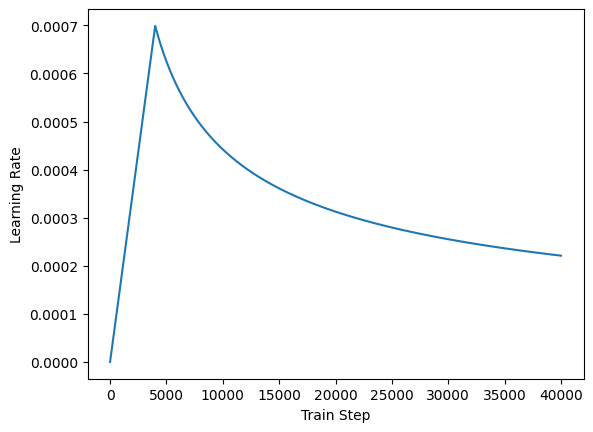

In [ ]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

drive_root = "/content/drive/MyDrive/hindi_transformer"

# Create directories if not exist
os.makedirs(drive_root, exist_ok=True)

checkpoint_filepath = os.path.join(drive_root, "checkpoint_hindi_transformer.keras")
csv_log_filepath = os.path.join(drive_root, "training_log_hindi_transformer.csv")
backup_dir = os.path.join(drive_root, "backup_hindi_transformer")
os.makedirs(backup_dir, exist_ok=True)


In [ ]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

csv_logger = callbacks.CSVLogger(csv_log_filepath, append=True)

backup_callback = callbacks.BackupAndRestore(
    backup_dir=backup_dir,
    delete_checkpoint=False
)

all_callbacks = [early_stopping, model_checkpoint_callback, csv_logger, backup_callback]


In [ ]:

epochs = 28
transformer.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
history = transformer.fit(train_ds,
                epochs=epochs,
                validation_data=test_ds ,
                callbacks=[
                      early_stopping ,
                      model_checkpoint_callback ,
                      csv_logger ,
                      backup_callback ] )

Epoch 1/28


In [ ]:
transformer.save('/content/V1-50k-106M.keras')


In [ ]:
import os
def plot_loss_and_accuracy(history, save_dir=None, filename=None):
    # Extract the loss and accuracy values from the history object
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Get the number of epochs
    epochs = range(1, len(loss) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    plt.show()
plot_loss_and_accuracy(history ,"/content/drive/MyDrive/NMT-Project", "V1-50k-106M_trainloss.png" )

In [ ]:
en_vocab = eng_vectorization.get_vocabulary()
en_index_lookup = dict(zip(range(len(en_vocab)), en_vocab))


In [ ]:
for batch in test_ds.take(1):
    inputs, targets = batch
    predictions = transformer(inputs, training=False)
    break
predicted_ids = tf.argmax(predictions, axis=-1)
hi_vocab = hi_vectorization.get_vocabulary()
en_vocab = eng_vectorization.get_vocabulary()

def decode_tokens(token_ids, vocab):
    return " ".join([vocab[t] for t in token_ids if t != 0])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'functional_11' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


### Testing on Random Train Samples

In [ ]:
# pick first sample in batch
encoder_input = inputs["encoder_inputs"][0].numpy()
ground_truth  = targets[5].numpy()
model_output  = predicted_ids[5].numpy()

print("Hindi (Input):")
print(decode_tokens(encoder_input, hi_vocab))

print("\nEnglish (Ground Truth):")
print(decode_tokens(ground_truth, en_vocab))

print("\nEnglish (Model Output):")
print(decode_tokens(model_output, en_vocab))


Hindi (Input):
अहम और कारण वाले [end] आयोग उसने के की देखिये पूरा

English (Ground Truth):
been striker and months becomes police names a where in much our your vision it beetle society had in of

English (Model Output):
your your on all on police and or where in of was relations large that names area had in of and and and and and a a and and


In [ ]:
# ========= PRINT MODEL OUTPUT (SAFE & CORRECT) =========

import tensorflow as tf

# Take one batch from test dataset
for batch in test_ds.take(1):
    inputs, targets = batch
    predictions = transformer(inputs, training=False)
    break

# Convert predictions to token IDs
predicted_ids = tf.argmax(predictions, axis=-1)

# Get vocabularies
hi_vocab = hi_vectorization.get_vocabulary()
en_vocab = eng_vectorization.get_vocabulary()

def decode_tokens(token_ids, vocab):
    return " ".join([vocab[t] for t in token_ids if t != 0])

# Select first sample in batch
encoder_input = inputs["encoder_inputs"][0].numpy()
ground_truth  = targets[0].numpy()
model_output  = predicted_ids[0].numpy()

print("Hindi (Input):")
print(decode_tokens(encoder_input, hi_vocab))

print("\nEnglish (Ground Truth):")
print(decode_tokens(ground_truth, en_vocab))

print("\nEnglish (Model Output):")
print(decode_tokens(model_output, en_vocab))


Hindi (Input):
अहम और कारण वाले [end] आयोग उसने के की देखिये पूरा

English (Ground Truth):
7500 jayasurya injury touches europe is this fixed uttara that going have of

English (Model Output):
having europe having this europe best this in than in going in of have have have have have have have have have have have have have have have have


In [ ]:
!pip install --quiet evaluate sacrebleu bert_score rouge_score


In [ ]:

import sacrebleu
import evaluate

# Assume text_pairs = [(english_sentence, hindi_reference), ...]
test_pairs = text_pairs[:200]

refs = [[ref.replace("[start] ", "").replace(" [end]", "") for _, ref in test_pairs]]
hyps = [decode_sequence(eng) for eng, _ in test_pairs]

# Store scores
scores = {}

# SacreBLEU
bleu = sacrebleu.corpus_bleu(hyps, refs)
scores["SacreBLEU"] = bleu.score

# METEOR
meteor = evaluate.load("meteor")
meteor_score = meteor.compute(predictions=hyps, references=refs[0])
scores["METEOR"] = meteor_score["meteor"]

# TER
ter = evaluate.load("ter")
ter_score = ter.compute(predictions=hyps, references=refs[0])
scores["TER"] = ter_score["score"]  # lower is better

# chrF++
chrf = evaluate.load("chrf")
chrf_score = chrf.compute(predictions=hyps, references=refs[0])
scores["chrF++"] = chrf_score["score"]

# BERTScore (semantic similarity)
try:
    bertscore = evaluate.load("bertscore")
    bertscore_score = bertscore.compute(predictions=hyps, references=refs[0], lang="en")
    scores["BERTScore (F1)"] = sum(bertscore_score["f1"]) / len(bertscore_score["f1"]) * 100
except Exception as e:
    print("BERTScore could not be computed:", e)

# ROUGE-L
rouge = evaluate.load("rouge")
rouge_score = rouge.compute(predictions=hyps, references=refs[0])
scores["ROUGE-L"] = rouge_score["rougeL"] * 100

# Print all scores
print("All metrics:")
for k, v in scores.items():
    print(f"{k}: {v:.4f}")

# Select top 3 scores (higher is better, TER is reversed)
sorted_scores = sorted(
    scores.items(),
    key=lambda x: x[1] if x[0] != "TER" else -x[1],
    reverse=True
)
print("\nTop 3 metrics:")
for metric, value in sorted_scores[:3]:
    print(f"{metric}: {value:.4f}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'functional_3' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


All metrics:
SacreBLEU: 3.3664
METEOR: 0.2285
TER: 125.6854
chrF++: 24.5112
BERTScore (F1): 87.3126
ROUGE-L: 0.0000

Top 3 metrics:
BERTScore (F1): 87.3126
chrF++: 24.5112
SacreBLEU: 3.3664


In [ ]:
# pick a random training pair
import random

sample = random.choice(train_pairs)

# HI → EN direction
input_sentence  = sample[0]   # Hindi (encoder input)
output_sentence = sample[1]   # English (ground truth)

# model prediction

print("========== MODEL I/O ==========")

print("\nINPUT to Encoder (Hindi):")
print(input_sentence)

print("\nEXPECTED OUTPUT (English - Ground Truth):")
print(output_sentence)




========== MODEL I/O ==========

INPUT to Encoder (Hindi):
And God,“ he said to the poor man, ”is answering your plea

EXPECTED OUTPUT (English - Ground Truth):
[start] “और भगवान्”, उन्होंने गरीब व्यक्ति से कहा, “तुम्हारी प्रार्थना सुन रहे हैं [end]
